# Определение возраста покупателей

## Описание проекта

 Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.\
 Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.
 
 
Нужно построить модель, которая по фотографии определит приблизительный возраст человека.
В распоряжении имеется набор фотографий людей с указанием возраста.

In [1]:
#Импортируем необходимые библиотеки:
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

## Исследовательский анализ данных

In [3]:
labels = pd.read_csv('/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


<div class="alert alert-block alert-success">
<b>Успех:</b> Хорошо, что ты не забываешь про первичный осмотр загруженного файла!
</div>

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


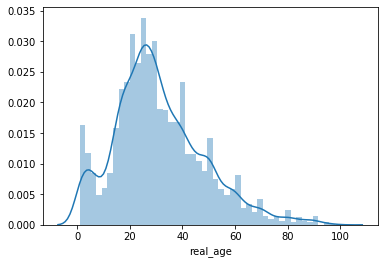

In [6]:
sns.distplot(labels['real_age'])

Оснавная часть выборки представлена людьми  20 - 40 лет. В выборке довольно мало людей престарелого возраста (старше 60).

In [77]:
labels = pd.read_csv('/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


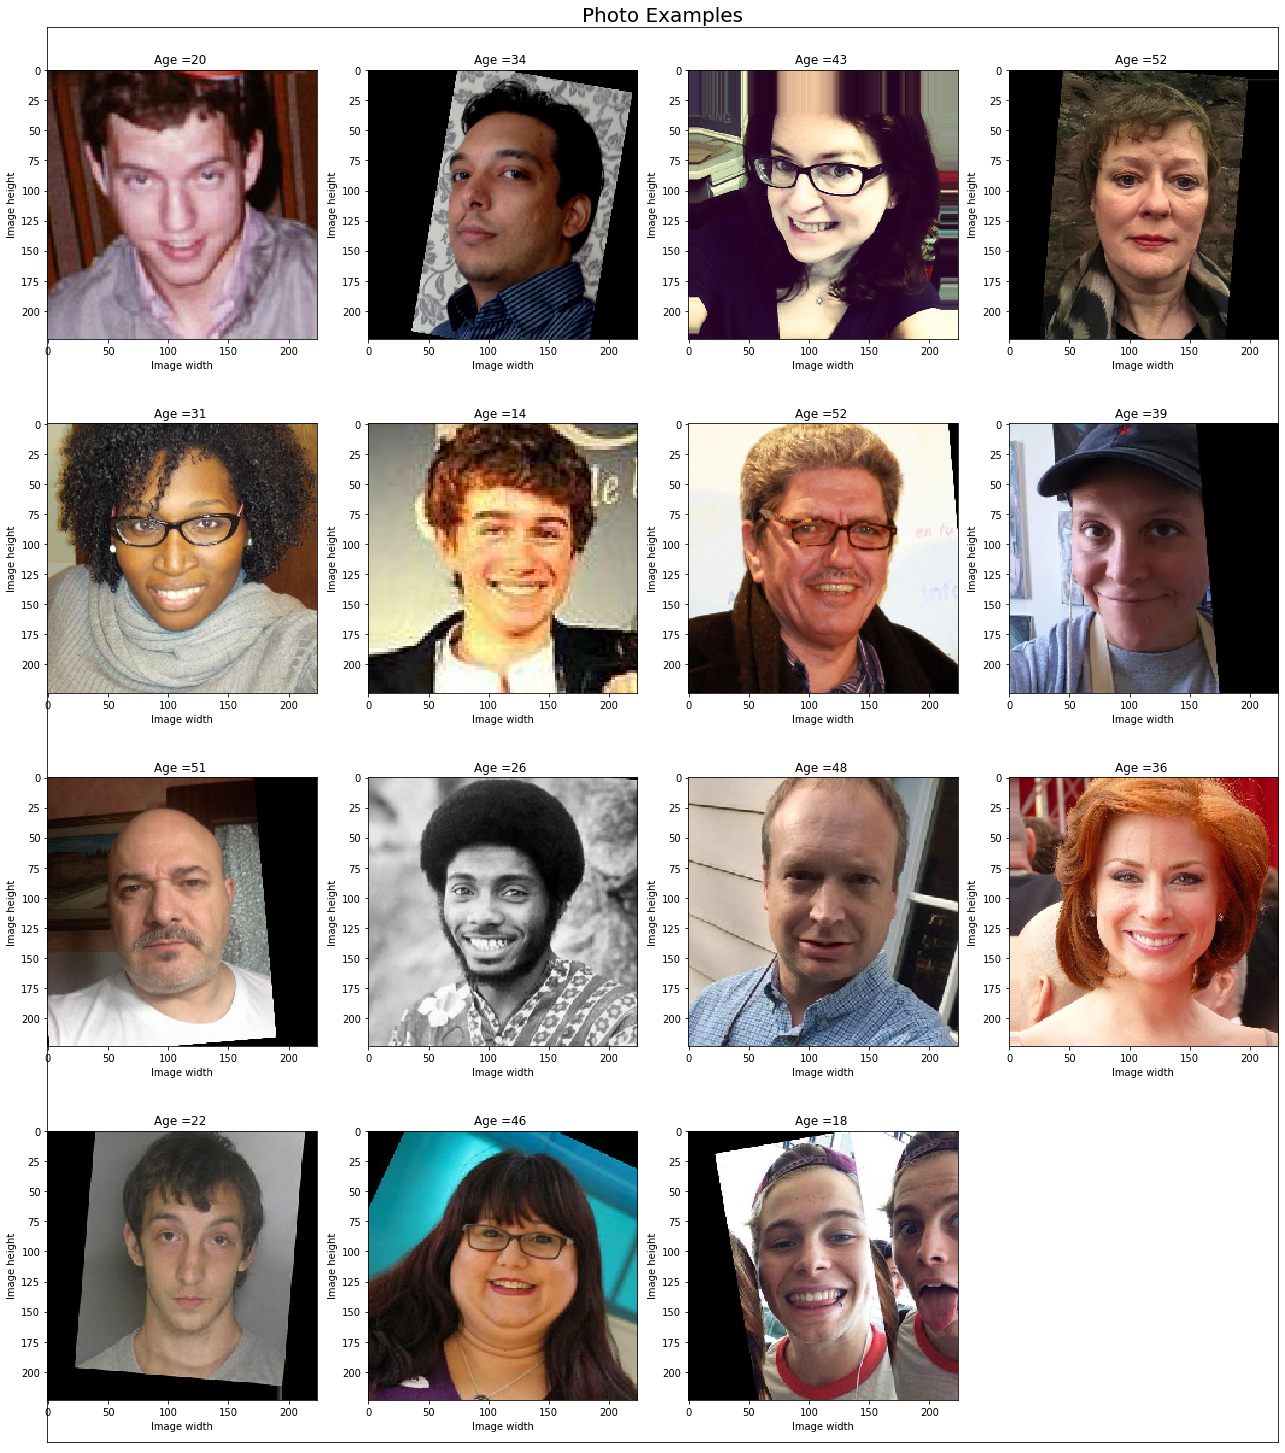

In [110]:
features, target = next(train_gen_flow)

# выводим 15 изображений

fig = plt.figure(figsize=(18,20))
plt.title('Photo Examples', {'fontsize': 20,
 'fontweight' : 10,
 'verticalalignment': 'baseline'})
plt.xticks([])
plt.yticks([])
plt.tight_layout()
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.tight_layout() 
    plt.title('Age ={} '.format(target[i]), loc='center')    
    plt.xlabel('Image width')
    plt.ylabel('Image height')



Имеем изображения с разным профилем лица, поворотом и цветами.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

Импортируем нужные библиотеки, создаем функции-загрузчики, определяем модель и тренируем ее:  

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf
 

def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, horizontal_flip=True)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset='training') 
    
    return train_gen_flow

def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset='validation') 
    
    return test_gen_flow






def create_model(input_shape):
 
    backbone = ResNet50(input_shape=(150, 150, 3),
                    weights='/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
 
 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```

Train for 190 steps, validate for 48 steps
Epoch 1/10

190/190 - 156s - loss: 195.7881 - mae: 10.5034 - val_loss: 478.7561 - val_mae: 16.6950
Epoch 2/10
190/190 - 37s - loss: 108.8684 - mae: 7.9739 - val_loss: 303.7850 - val_mae: 12.9763
Epoch 3/10
190/190 - 37s - loss: 90.9563 - mae: 7.2764 - val_loss: 344.3412 - val_mae: 13.7349
Epoch 4/10
190/190 - 37s - loss: 70.2215 - mae: 6.3832 - val_loss: 161.0419 - val_mae: 9.6246
Epoch 5/10
190/190 - 37s - loss: 56.3829 - mae: 5.6997 - val_loss: 113.9031 - val_mae: 7.7557
Epoch 6/10
190/190 - 37s - loss: 45.8878 - mae: 5.1782 - val_loss: 110.2434 - val_mae: 8.1045
Epoch 7/10
190/190 - 39s - loss: 37.2375 - mae: 4.6642 - val_loss: 86.9976 - val_mae: 7.2834
Epoch 8/10
190/190 - 37s - loss: 36.5477 - mae: 4.6153 - val_loss: 123.0403 - val_mae: 8.2386
Epoch 9/10
190/190 - 37s - loss: 32.1088 - mae: 4.3206 - val_loss: 80.2254 - val_mae: 6.7516
Epoch 10/10
190/190 - 37s - loss: 29.2869 - mae: 4.1767 - val_loss: 77.7696 - val_mae: 6.5671


```

### Вывод: 
#### Проведен исследовательский анализ данных на датасете с изображениями лиц людей различного возраста.
Обучена нейронная сеть ResNet50 для предсказания возраста по фото.\ 
Нейронная сеть предобучена на ImageNet и состоит из 50 слоев: первые blackbone (костяк), последние слои: GlobalAveragePooling2D - пулинг с окном во весь тензор, Dense — полносвязный слой для классификации.\
Оптимизация модели реализована алгоритмом Adam с параметром lr = 0.005, подобранным экспериментально.\
Задана функция потерь MSE, для ускорения обучения, в конце каждой эпохи (всего задано 10 эпох) обучения выводится метрика MAE на тестовой выборке.\
На обучающей выборке применена аугментация - горизонтальный флип для снижения эффекта переобучения модели.\
Удалось достичь метрики MAE ниже 7.\

Построенная модель позволяет решить поставленную бизнесом задачу по анализу покупок и предложению товаров, которые могут заинтересовать покупателей этой возрастной группы; задачу по контролю добросовестности кассиров при продаже алкоголя модель решить не поможет т.к. она определяет по фотографии приблизительный возраст человека с погрешностью до 7 лет.